# ***Final Project***
### ***CS181/DA210: Data Systems*** 
***Submitted By: Niranjan Reji*** 
<br>
*22nd April 2022*

---

In [1]:
import os
import sys
import importlib
import pandas as pd
from matplotlib import pyplot as plt
from lxml import etree
import json

if os.path.isdir(os.path.join("../../..", "modules")):
    module_dir = os.path.join("../../..", "modules")
else:
    module_dir = os.path.join("../..", "modules")

module_path = os.path.abspath(module_dir)
if not module_path in sys.path:
    sys.path.append(module_path)

import util
importlib.reload(util)
htmlparser = etree.HTMLParser()
import sqlalchemy as sa

# ***Central Questions***

My central goal in this project is to find out who the fastest Formula 1 driver has been over different periods of time in the last 8 years. Formula 1 is comprised of yearly seasons, with the best driver in the sport being crowned the drivers champion each season. These drivers travel to multiple tracks each season, and participate in "Qualifying" sessions where they set the fastest time they can around the track to set the order they start in for each race. To do this, I scrape data from: 

---

https://en.wikipedia.org/api/rest_v1/page/html/List_of_Formula_One_drivers <br>
https://www.formula1.com/en/results.html/2016/races.html <br>
***The F1 website URL above changes for each year we're scraping data from.*** <br>

---

I choose to average out the qualifying times of drivers over multiple years to see which drivers have the fastest average times and rank them by this criteria. This approach ignores car performance (some cars are better than other cars in the sport), but still tells us who the fastest has been on average and is a useful way to compare rivals who used to have evenly matched cars.

<br>

# ***Database Setup***

For our database, we are going to construct two tables - one is the wikipedia table of formula one drivers that we pull from the internet, and our second one is a list of qualifying times set by drivers during a specific qualifying session at a specific track during a specific year.

This database eliminates redundant data by not storing driver information in our qualifying results table, as the same drivers appear repeatedly in it. Both of our tables also share columns with which we can join them to each other and get driver information along with their qualifying times.

---

In [2]:
def getsqlite_creds(dirname=".",filename="creds.json"):

    """ 
    Using directory and filename parameters, open a credentials file
    and obtain the two parts needed for a connection string to
    a local provider using the "sqlite" dictionary within
    an outer dictionary.  
        
    Return a scheme and a dbfile
    """
    
    assert os.path.isfile(os.path.join(dirname, filename))
    with open(os.path.join(dirname, filename)) as f:
        D = json.load(f)
    sqlite = D["sqlite"]
    return sqlite["scheme"], sqlite["dbdir"], sqlite["database"]

In [3]:
%load_ext sql

In [4]:
scheme, dbdir, database = getsqlite_creds()
template = '{}:///{}/{}.db'
cstring = template.format(scheme, dbdir, database)
print("Connection string:", cstring)

Connection string: sqlite:///f1data/f1data.db


In [5]:
%sql $cstring

I'm also using **SQL Alchemy** here (along with command line sql execution through python) to pull the Wikipedia table of F1 drivers and put it into our database, as it interfaces pretty well with Pandas. The only problem is the function I use isn't great at setting the column datatypes on its own, but since I'm only using this Wikipedia table for driver information, we don't need to do anything here.

In [6]:
engine = sa.create_engine(cstring)
connection = engine.connect()

Now, I run a shell query to curl the driver's list into our working directory. We're not going to use this html file, though. 

In [7]:
site = 'https://en.wikipedia.org/api/rest_v1/page/html/List_of_Formula_One_drivers'
shellQuery4 = f'cd HTML/drivers && curl -s -o driversList.html {site}'
!{shellQuery4}

And now I simply read the table from wikipedia into a DataFrame using the URL I have!

In [8]:
driversDF = pd.read_html(site)[2]
driversDF

,Driver Name,Nationality,Seasons Competed,Drivers' Championships,Race Entries,Race Starts,Pole Positions,Race Wins,Podiums,Fastest laps,Points[lower-alpha 1]
0,Carlo Abate,Italy,1962–1963,0,3,0,0,0,0,0,0
1,George Abecassis,United Kingdom,1951–1952,0,2,2,0,0,0,0,0
2,Kenny Acheson,United Kingdom,"1983, 1985",0,10,3,0,0,0,0,0
3,Andrea de Adamich,Italy,"1968, 1970–1973",0,36,30,0,0,0,0,6
4,Philippe Adams,Belgium,1994,0,2,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
861,Zhou Guanyu*,China,2022,0,4,3,NaN,NaN,NaN,NaN,1
862,Ricardo Zonta,Brazil,"1999–2001, 2004–2005",0,37,36,0,0,0,0,3
863,Renzo Zorzi,Italy,1975–1977,0,7,7,0,0,0,0,1
864,Ricardo Zunino,Argentina,1979–1981,0,11,10,0,0,0,0,0


Now I add a few finishing touches to this Dataframe, since information in the Driver Name column has a few names with symbols at their end (Look at ***Zhou Guanyu**** in the DataFrame above). This would be fine if I wasn't planning to join data from this table to our table of qualifying results (coming up in a bit), but I am. We join these two tables to pull up information about a Driver when we see how they are ranked as well.

In [9]:
l = list(driversDF['Driver Name'])
newL = []
for i in l:
    if not i[-1].isalpha(): newL.append(i[:-1])
    else: newL.append(i)
newL
driversDF['DriverName'] = newL
driversDF.drop(['Driver Name'], axis=1, inplace=True)
driversDF.head()

,Nationality,Seasons Competed,Drivers' Championships,Race Entries,Race Starts,Pole Positions,Race Wins,Podiums,Fastest laps,Points[lower-alpha 1],DriverName
0,Italy,1962–1963,0,3,0,0,0,0,0,0,Carlo Abate
1,United Kingdom,1951–1952,0,2,2,0,0,0,0,0,George Abecassis
2,United Kingdom,"1983, 1985",0,10,3,0,0,0,0,0,Kenny Acheson
3,Italy,"1968, 1970–1973",0,36,30,0,0,0,0,6,Andrea de Adamich
4,Belgium,1994,0,2,2,0,0,0,0,0,Philippe Adams


And now I move the table to our f1data database.

In [10]:
driversDF.to_sql('drivers_list', con=connection, if_exists='replace')

866

The second table in our database is going to be a table of results. At every track within a given season (year), drivers set the fastest time they can during qualifying, and all this table will do is collect these times using this mapping of independent to dependent variables.

***(Driver Name, Year, Track) -> (Qualifying Time)***

Qualifying Time is listed as Quali in this new table, and DriverName, Year, and Track are the other three columns. DriverName, Year, and Track end up being our primary keys.

In [11]:
resultsQuery = '''
CREATE TABLE IF NOT EXISTS results (
    DriverName varchar(30) NOT NULL,
    Year int(4) NOT NULL,
    Track varchar(30) NOT NULL,
    Quali double NULL,
    PRIMARY KEY (DriverName, Year, Track)
)
'''
%sql $resultsQuery

 * sqlite:///f1data/f1data.db
Done.


[]

# ***Webscraping***


For this project, I have chosen to curl all of the html that we need to parse from the Formula 1 website. The problem, though, is that qualifying times for all years we want to access are not available at a single URL. The main results website holds links to results for multiple years, each of these sites for specific years holds a link to a track raced on in that year, and each of THESE sites holds a link to times set in Qualifying. 

The final site we access through this maze holds qualifying times set at a specific track in a specific year, by all the drivers that were active during that year. Clearly, if we want data from multiple years and all tracks during these years, we will have to build nested loops to iterate through these sub-links and scrape data from each qualifying link, one by one. 

The cells ahead define functions that execute pieces of this process. The last cell should take ***close to 5 minutes to execute***, as it scrapes all of this data and inserts it into our SQL database. There are thousands of records that are being scraped and iterated through, making this significantly slower than what we would ideally like. These functions also use ***shell commands combined together*** (cd and curl) to put our files into organized folders.

To summarize, here's how the website we are webscraping from is organized, where each arrow represents a link on the page it originates from.

***(main page) -> (year of season) -> (track) -> (qualifying results - table stored here to be scraped!)*** 

---

The first function below curls the html webpage for a specific year, passed to it as an argument. It stores the html in the HTML/year directory as year.html. It also finds the ***list of races in that specific year*** (as all the races in that year will appear as links on this page), and builds a list of the URLs of the pages for each race which it returns (the URL is scraped from @href for <\a> tags, and only contains the resource part of URLs, not the location.)

In [12]:
def yearSite(i):
    site = f'https://www.formula1.com/en/results.html/{i}/races.html'
    shellQuery = f'cd HTML/{i} && curl -s -o {i}.html {site}'
    !{shellQuery}

    tree = etree.parse(f'HTML/{i}/{i}.html', parser=htmlparser)
    races = tree.xpath('//div[@class="resultsarchive-filter-wrap" and position()=3]//li/a/@href')[1:]
    return races

We might have a list of tracks active for the year from the site we pull from the function above, but that doesn't give us the names of each of these tracks. It turns out that the resource URL we get in yearSite() contains the name of the track after a few backslashes - using this information, we pull tracknames with the function below. This function also curls the html for the page of each track of the year we're in. In the main code block that calls all of our functions, I call the return value filename as we also use the trackname as our filename (we're putting them in different folders for years, so there shouldn't be any conflicts anywhere.)

In [13]:
def trackName(j):
    trackname = ''
    slashCount = 0
    for k in range(49):
        if j[k] == '/' and slashCount <= 6: 
            slashCount += 1
            continue
        elif slashCount == 6: trackname += j[k]
        elif slashCount > 6: break

    subsite = 'https://www.formula1.com' + j
    shellQuery2 = f'cd HTML/{i}/race && curl -s -o {trackname}.html {subsite}'
    !{shellQuery2}
    
    return trackname

The function below now searches for a link to the Qualifying results for the race and year we're already at, creates a URL to scrape from, and curls the HTML for that URL. It also creates a tree of the HTML of this new page, and returns it. 

In [14]:
def quali(racetree, filename, i):

    quali = str(racetree.xpath('//ul[@class="resultsarchive-side-nav"]//a[text()="Qualifying"]/@href')[0])

    qualisite = 'https://www.formula1.com' + quali
    shellQuery3 = f'cd HTML/{i}/qualifying && curl -s -o {filename}q.html {qualisite}'
    !{shellQuery3}

    qualiTree = etree.parse(f'HTML/{i}/qualifying/{filename}q.html', parser=htmlparser)
    return qualiTree

The first part of the function below first grabs the HTML of the table with qualifying results, and then grabs the times set by all drivers during qualifying in a list. The first for loop iterates through this list and changes the format of these times from Minutes:Seconds:Milliseconds to a simple float value with the total number of seconds. It also checks for 'DNF's (did not finish), and puts in a Nonetype object for the time when that happens. 

After this, the function pulls out the names of the drivers, and then we run a for loop to join together elements in the resulting list (we end up getting first and last names seperated initially, and also get the first three letters of their last names which we have to eliminate.) Finally, we return qualifying times and the names of the drivers who set these times in two lists. 

In [15]:
def qualiTableParser(qualiTree):

    qualiTable = qualiTree.xpath('//table[@class="resultsarchive-table"]')[0]
    qualiTime = qualiTable.xpath('//td[position()=6]/text()')

    for l in range(len(qualiTime)):
        if qualiTime[l][0] != 'D':
            qualiTime[l] = float(qualiTime[l][0])*60 + float(qualiTime[l][2:4]) + float(qualiTime[l][5:8])/1000
        else:
            qualiTime[l] = None 

    qualiName = qualiTable.xpath('//td[@class="dark bold"]/span/text()')

    for w in range(0, len(qualiName)):
        qualiName[w:w+3] = [' '.join(qualiName[w:w+2])]
    qualiName = [i for i in qualiName if i != '']
    
    return qualiTime, qualiName

And finally, we call all these functions! After qualiTableParser() is called, we have a bit of code to insert driver names, the year, the track name (written as filename here) and the time they set during qualifying. 

We also place a significant part of this code in a try block, as the links to qualifying results don't exist for races that haven't happened yet during 2022. When we run into this problem, we delete the HTML file we saved for that specific race as well. Neat! Another nice thing about this webscraping code is it will work for a long time into the foreseeable future and scrape new races too, until the Formula 1 website changes their format for their URLs or significantly changes the HTML used on their page.

In the block of code below, the range for i is the list of years we're pulling from, and j iterates through the races of each of these years.

In [16]:
for i in range(2014, 2023):

    races = yearSite(i)

    for j in races:

        filename = trackName(j)

        racetree = etree.parse(f'HTML/{i}/race/{filename}.html', parser=htmlparser)
        
        try:

            qualiTree = quali(racetree, filename, i)

            qualiTime, qualiName = qualiTableParser(qualiTree)

            for m in range(len(qualiName)):
                if qualiTime[m] == None: continue
                query = f'''
                INSERT INTO results values (
                    '{qualiName[m]}', {i}, '{filename}', {qualiTime[m]}
                )
                '''
                %sql $query
        except Exception as e:
            os.remove(f"HTML/{i}/race/{filename}.html")

 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:///f1data/f1data.db
 * sqlite:

# ***The Data***

We've put everything into a database! Let's figure out who our fastest drivers for the past 8 years has been. To do this, we first group by drivers and then take an average of all of their qualifying times. 

Also, to eliminate weird gremlins in our results, we put in ***HAVING COUNT(Quali) > 60*** - it's possible that some of the listed drivers on the website only appeared for a race or two as a substitute, and if they appeared at a short track, their average qualifying time would be skewed. We also do an inner join with our drivers list (the type of join shouldn't matter here, really, as all F1 drivers must exist in our drivers list and some subset of them are in our qualifying times table.) We also use 60 here to offset how the data skews towards newcomers who are in faster cars from the beginning. 

In [17]:
query = '''
SELECT DriverName, Nationality, [Race Entries], [Race Wins], [Podiums], AVG(Quali) as avg FROM Results INNER JOIN drivers_list USING (DriverName) GROUP BY DriverName HAVING COUNT(Quali) > 60 ORDER BY avg LIMIT 10
'''

%sql $query

 * sqlite:///f1data/f1data.db
Done.


DriverName,Nationality,Race Entries,Race Wins,Podiums,avg
Charles Leclerc,Monaco,85,4,16,85.4636282051282
Pierre Gasly,France,90,1,3,85.9067926829268
Max Verstappen,Netherlands,145,21,61,87.2258731343284
Lance Stroll,Canada,105,None,3,87.25060638297873
Esteban Ocon,France,93,1,2,87.67363529411767
Lewis Hamilton,United Kingdom,292,103,183,87.73665584415585
Valtteri Bottas,Finland,183,10,67,88.1076751592357
Sebastian Vettel,Germany,282,53,122,88.20728758169935
Daniel Ricciardo,Australia,214,8,32,88.39903821656047
Kimi Räikkönen,Finland,353,21,103,88.59698026315789


That's weird, but with changing performance and drivers changing teams constantly, it's not extremely surprising. How about the last 4 years? I also use a left join here.

In [18]:
query = '''
SELECT DriverName, Nationality, [Race Entries], [Race Wins], [Podiums], AVG(Quali) as avg FROM Results LEFT JOIN drivers_list USING (DriverName) WHERE Year > 2017 GROUP BY DriverName HAVING COUNT(Quali) > 20 ORDER BY avg LIMIT 10
'''

%sql $query

 * sqlite:///f1data/f1data.db
Done.


DriverName,Nationality,Race Entries,Race Wins,Podiums,avg
Max Verstappen,Netherlands,145,21,61,85.00453333333331
Lewis Hamilton,United Kingdom,292,103,183,85.11992307692309
Valtteri Bottas,Finland,183,10,67,85.22115384615383
Yuki Tsunoda,Japan,26,None,None,85.26509523809524
Sebastian Vettel,Germany,282,53,122,85.44417333333334
Charles Leclerc,Monaco,85,4,16,85.4636282051282
Fernando Alonso,Spain,340,32,98,85.60166666666666
Lando Norris,United Kingdom,64,None,5,85.6439649122807
Daniel Ricciardo,Australia,214,8,32,85.69864102564101
Sergio Perez,None,None,None,None,85.75235064935063


Let's also take a look at 2022.

In [19]:
query = '''
SELECT DriverName, Nationality, [Race Entries], [Race Wins], [Podiums], AVG(Quali) as avg FROM Results LEFT JOIN drivers_list USING (DriverName) WHERE Year = 2022 GROUP BY DriverName HAVING COUNT(Quali) > 3 ORDER BY avg LIMIT 10
'''

%sql $query

 * sqlite:///f1data/f1data.db
Done.


DriverName,Nationality,Race Entries,Race Wins,Podiums,avg
Charles Leclerc,Monaco,85,4,16,84.54675
Max Verstappen,Netherlands,145,21,61,84.647
Carlos Sainz,None,None,None,None,84.67750000000001
Sergio Perez,None,None,None,None,85.15575
Valtteri Bottas,Finland,183,10,67,85.318
Lando Norris,United Kingdom,64,None,5,85.411
Fernando Alonso,Spain,340,32,98,85.4285
George Russell,United Kingdom,64,None,2,85.43425
Zhou Guanyu,China,4,None,None,85.52775
Kevin Magnussen,Denmark,124,None,1,85.54675


That makes a lot more sense! Max Verstappen and Lewis Hamilton have fought at the front of the field for much of the past few years, and it's nice to verify that our method of analysis works here. The average gap in between them speaks to their skill, too - just a tenth of a second! How about just 2021? (2021 was one of the most closely fought seasons in the sport's history!)

The data from 2022 makes sense as well. Charles Leclerc has been performing incredibly well throughout the opening of this season.

In [20]:
query = '''
SELECT DriverName, Nationality, [Race Entries], [Race Wins], [Podiums], AVG(Quali) as avg FROM Results LEFT JOIN drivers_list USING (DriverName) WHERE Year = 2021 GROUP BY DriverName HAVING count(Quali) > 10 ORDER BY avg
'''

%sql $query

 * sqlite:///f1data/f1data.db
Done.


DriverName,Nationality,Race Entries,Race Wins,Podiums,avg
Max Verstappen,Netherlands,145,21,61,83.25994736842105
Lewis Hamilton,United Kingdom,292,103,183,84.42339999999999
Valtteri Bottas,Finland,183,10,67,84.57894999999999
Sergio Perez,None,None,None,None,84.69295
Antonio Giovinazzi,Italy,62,None,None,84.6931052631579
Lando Norris,United Kingdom,64,None,5,84.71185
Charles Leclerc,Monaco,85,4,16,84.8216
Pierre Gasly,France,90,1,3,84.87375
Carlos Sainz,None,None,None,None,84.92675
Daniel Ricciardo,Australia,214,8,32,85.16125


Verstappen again! As a Verstappen fan, this makes me glad. Let's graph our results using the same query, some SQL Alchemy, and pyplot.

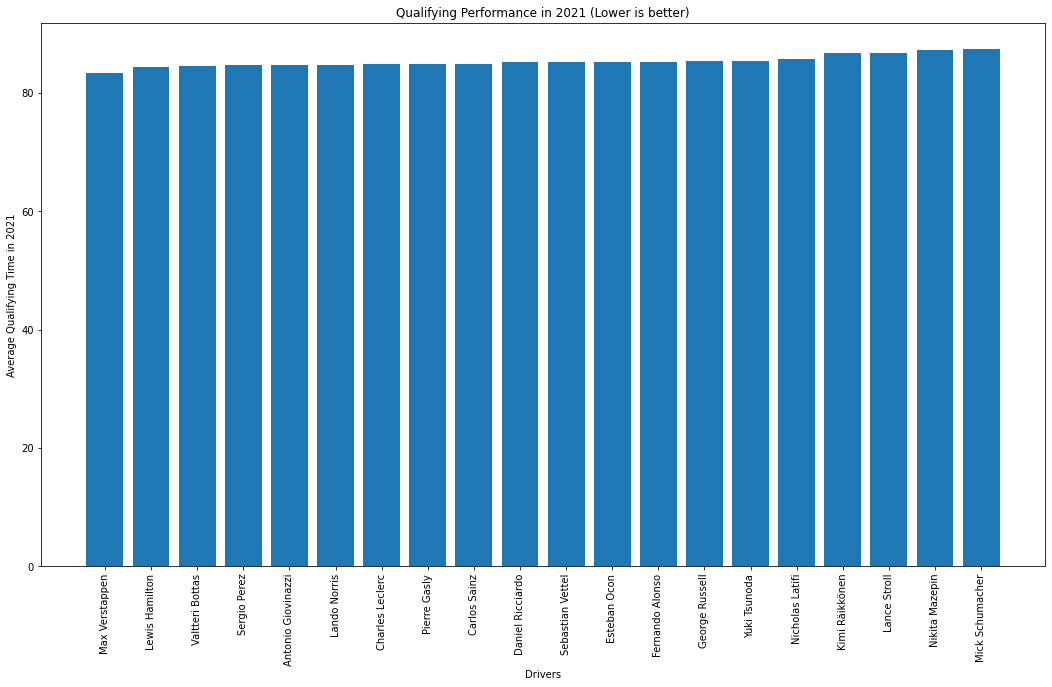

In [21]:
result = connection.execute(query)

xlabel = []
ylabel = []
for i in result:
    xlabel.append(i[0])
    ylabel.append(i[5])

plt.figure(figsize=(18, 10))
plt.bar(xlabel, ylabel)
plt.xlabel('Drivers')
plt.ylabel('Average Qualifying Time in 2021')
plt.title('Qualifying Performance in 2021 (Lower is better)')
plt.xticks(rotation = 90)
plt.show()



# ***Our Results***

My central goal in this project was to find the fastest driver over different periods of time lying within the past 8 years, and here are our results:

Over the past 8 years, the fastest driver on average has been ***Charles Leclerc***. (when attempting offsets for newer drivers who have been faster from the beginning)

Over the past 4 years, the fastest driver on average has been ***Max Verstappen***, followed quite closely by ***Lewis Hamilton***. (matches up with the sport in real life!)

In the 2021 season, the fastest driver on average was ***Max Verstappen*** yet again! And in 2022, it looks like ***Charles Leclerc*** is the fastest for now.